# DATA LOADING

In [1]:
import pandas as pd
import numpy as np
from random_forest_scratch import RandomForestScratch
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)

DATA_PATH = "earthquake_1995-2023.csv"
df = pd.read_csv(DATA_PATH, low_memory=False)
alert_mapping = {
    'none': 0,
    'green': 1,
    'yellow': 2,
    'orange': 3,
    'red': 4
}

df['alert_encoded'] = df['alert'].fillna('none').map(alert_mapping)
df_clean = df.select_dtypes(include=[np.number])

X = df_clean.drop('tsunami', axis=1).values
y = df_clean['tsunami'].values

print(f"Data loaded. Shape of X: {X.shape}, Shape of y: {y.shape}")

Data loaded. Shape of X: (1000, 11), Shape of y: (1000,)


# RANDOM FOREST FROM SCRATCH HYPERPARAMETERS


In [8]:
import itertools
import pandas as pd

param_grid = {
    'n_trees': [10, 20],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5]
}

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"Searching for best hyperparameters among {len(param_combinations)} combinations...")

best_score = 0
best_std = 0
best_params = {}
grid_results_storage = []

for params in param_combinations:
    inner_kf = KFold(n_splits=3, shuffle=True, random_state=42)
    fold_accs = []

    for t_idx, v_idx in inner_kf.split(X):
        clf_temp = RandomForestScratch(**params)
        clf_temp.fit(X[t_idx], y[t_idx])
        preds = clf_temp.predict(X[v_idx])
        fold_accs.append(accuracy_score(y[v_idx], preds))

    mean_acc = np.mean(fold_accs)
    std_acc = np.std(fold_accs)

    result_entry = params.copy()
    result_entry['Mean_Accuracy'] = mean_acc
    result_entry['Std_Dev'] = std_acc
    grid_results_storage.append(result_entry)

    if mean_acc > best_score:
        best_score = mean_acc
        best_std = std_acc
        best_params = params
    elif mean_acc == best_score:

        if std_acc < best_std:
            best_std = std_acc
            best_params = params

grid_results_df = pd.DataFrame(grid_results_storage).sort_values(by='Mean_Accuracy', ascending=False)

print("\n" + "="*85)
print(f"{'n_trees':<8} | {'depth':<6} | {'min_split':<10} | {'Mean Acc':<12} | {'Std Dev':<10}")
print("-" * 85)

for _, row in grid_results_df.iterrows():
    print(f"{int(row['n_trees']):<8} | {int(row['max_depth']):<6} | {int(row['min_samples_split']):<10} | "
          f"{row['Mean_Accuracy']:.4f}       | +/- {row['Std_Dev']:.4f}")

print("="*85)
print(f"Search Complete. Best Params: {best_params} (Score: {best_score:.4f})\n")

Searching for best hyperparameters among 12 combinations...

n_trees  | depth  | min_split  | Mean Acc     | Std Dev   
-------------------------------------------------------------------------------------
20       | 20     | 2          | 0.9290       | +/- 0.0037
20       | 5      | 5          | 0.9270       | +/- 0.0036
20       | 5      | 2          | 0.9270       | +/- 0.0079
10       | 20     | 2          | 0.9250       | +/- 0.0042
10       | 20     | 5          | 0.9240       | +/- 0.0062
20       | 10     | 2          | 0.9220       | +/- 0.0065
20       | 20     | 5          | 0.9210       | +/- 0.0171
20       | 10     | 5          | 0.9210       | +/- 0.0057
10       | 10     | 5          | 0.9200       | +/- 0.0037
10       | 5      | 2          | 0.9180       | +/- 0.0092
10       | 10     | 2          | 0.9180       | +/- 0.0038
10       | 5      | 5          | 0.9140       | +/- 0.0098
Search Complete. Best Params: {'n_trees': 20, 'max_depth': 20, 'min_samples_split': 2}

# RANDOM FOREST FROM SCRATCH RUN WITH BEST HYPERPARAMETERS


In [9]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
metrics_storage = {
    'Accuracy': [],
    'Precision': [],
    'Recall (Sensitivity)': [],
    'F-Measure': [],
    'AUC (ROC)': [],
    'AUPRC': []
}

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = RandomForestScratch(
        n_trees=best_params['n_trees'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split']
    )

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_prob(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    if len(np.unique(y_test)) > 1:
        auc = roc_auc_score(y_test, y_prob)
        auprc = average_precision_score(y_test, y_prob)
    else:
        auc = 0.0
        auprc = 0.0

    metrics_storage['Accuracy'].append(acc)
    metrics_storage['Precision'].append(prec)
    metrics_storage['Recall (Sensitivity)'].append(rec)
    metrics_storage['F-Measure'].append(f1)
    metrics_storage['AUC (ROC)'].append(auc)
    metrics_storage['AUPRC'].append(auprc)

    print(f"Fold {fold + 1}: Acc={acc:.3f} | F1={f1:.3f} | AUC={auc:.3f}")

Fold 1: Acc=0.905 | F1=0.853 | AUC=0.966
Fold 2: Acc=0.930 | F1=0.910 | AUC=0.970
Fold 3: Acc=0.930 | F1=0.904 | AUC=0.969
Fold 4: Acc=0.950 | F1=0.917 | AUC=0.983
Fold 5: Acc=0.900 | F1=0.831 | AUC=0.963


# Statystical analysis and summary table for the scratch implementation

In [10]:
print("\n" + "=" * 60)
print(f"{'Metric':<25} | {'Mean':<10} | {'Std Dev':<10}")
print("=" * 60)

results_summary = {}

for metric, values in metrics_storage.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    results_summary[metric] = (mean_val, std_val)

    print(f"{metric:<25} | {mean_val:.4f}     | +/- {std_val:.4f}")

print("=" * 60)


Metric                    | Mean       | Std Dev   
Accuracy                  | 0.9230     | +/- 0.0183
Precision                 | 0.8602     | +/- 0.0471
Recall (Sensitivity)      | 0.9091     | +/- 0.0459
F-Measure                 | 0.8829     | +/- 0.0346
AUC (ROC)                 | 0.9705     | +/- 0.0068
AUPRC                     | 0.9066     | +/- 0.0181


# LIBRARY IMPLEMENTATION (Scikit-Learn) & COMPARISON

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5]
}

rf_library = RandomForestClassifier(random_state=5)
grid_search = GridSearchCV(estimator=rf_library, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)

best_rf_library = grid_search.best_estimator_
print(f"Best Library Params: {grid_search.best_params_}")

scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

library_results = cross_validate(best_rf_library, X, y, cv=kf, scoring=scoring_metrics)

print("\n" + "=" * 60)
print(f"{'Metric (Library)':<25} | {'Mean':<10} | {'Std Dev':<10}")
print("=" * 60)

print(
    f"{'Accuracy':<25} | {library_results['test_accuracy'].mean():.4f}     | +/- {library_results['test_accuracy'].std():.4f}")
print(
    f"{'Precision':<25} | {library_results['test_precision'].mean():.4f}     | +/- {library_results['test_precision'].std():.4f}")
print(
    f"{'Recall':<25} | {library_results['test_recall'].mean():.4f}     | +/- {library_results['test_recall'].std():.4f}")
print(f"{'F1-Measure':<25} | {library_results['test_f1'].mean():.4f}     | +/- {library_results['test_f1'].std():.4f}")
print(
    f"{'AUC (ROC)':<25} | {library_results['test_roc_auc'].mean():.4f}     | +/- {library_results['test_roc_auc'].std():.4f}")
print("=" * 60)

Best Library Params: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 50}

Metric (Library)          | Mean       | Std Dev   
Accuracy                  | 0.8980     | +/- 0.0181
Precision                 | 0.7784     | +/- 0.0443
Recall                    | 0.9565     | +/- 0.0121
F1-Measure                | 0.8577     | +/- 0.0289
AUC (ROC)                 | 0.9653     | +/- 0.0109


# INTERPRETABILITY (SHAP) FOR SCRATCH MODEL

  0%|          | 0/100 [00:00<?, ?it/s]

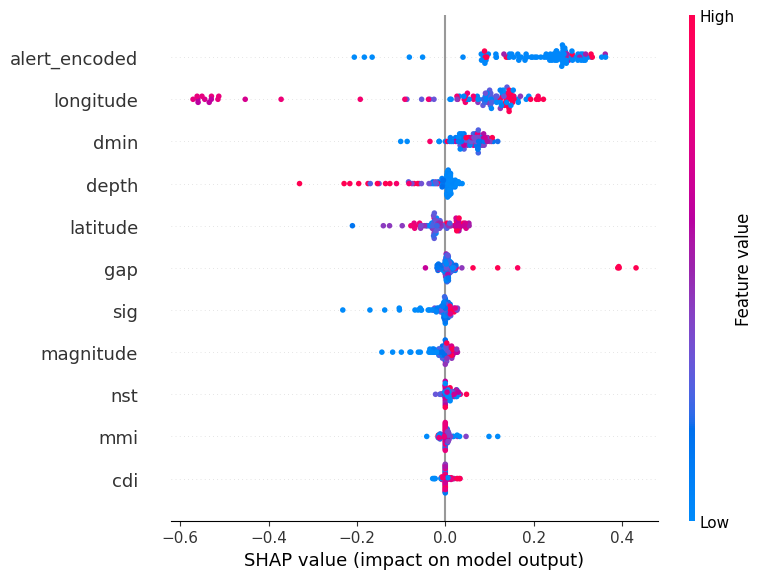

In [12]:
import shap

background_data = shap.kmeans(X, 50)
explainer = shap.KernelExplainer(clf.predict_prob, background_data)

X_explain = X[:100]
shap_values = explainer.shap_values(X_explain)

feature_names = df_clean.drop('tsunami', axis=1).columns.tolist()

shap.summary_plot(shap_values, X_explain, feature_names=feature_names)